# Synthetic seismogram

Let's make a synthetic with open source software! (And data!!)

This notebook uses `bruges`, `welly` (which uses `lasio`) and `segyio`.

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## Load well logs: `welly` and `lasio`

We'll use `welly` to faciliate loading curves from an LAS file.

In [2]:
from welly import Well

l30 = Well.from_las('../data/L-30.las')

In [3]:
dt = l30.data["DT"]
rhob = l30.data["RHOB"]

In [4]:
rhob

Curve([nan, nan, nan, ..., nan, nan, nan])

Compute velocity and thus acoustic impedance.

In [5]:
dt /= 0.3048
rhob *= 1000

l30.data['DT'] = dt
l30.data['RHOB'] = rhob

vp = 1e6 / dt
ai = vp * rhob

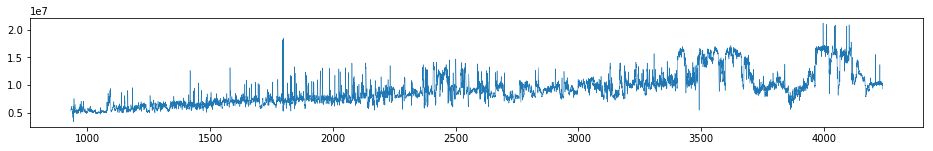

In [6]:
plt.figure(figsize=(16, 2))
plt.plot(dt.basis, ai, lw=0.5)

## Depth to time conversion: `numpy` for now

In [12]:
kb = 0.3048 * l30.las.header['Well']['KB'].value
gl = 0.3048 * l30.las.header['Well']['GL'].value

v_repl = 1800

In [13]:
def time_convert(log, dt_time, delt=0.004, maxt=None):
    """
    Converts log to the time domain, given dt_time, delt, and maxt.
    
    dt_time is elapsed time regularly sampled in depth. log must
    be sampled on the same depth basis.
    """
    maxt = maxt or np.ceil(dt_time[-1])
    seis_time = np.arange(0, maxt, delt)
    return np.interp(seis_time, dt_time, log), seis_time

In [14]:
def compute_dt_time(dt, kb, gl, v_repl, v_water=1480):
    """
    Compute DT time from the dt log and some other variables.
    
    The DT log must be a welly curve object.
    """
    start = dt.start

    v_repl = v_repl or 1800

    water_layer = -gl
    repl_layer = start + gl
    
    water_twt = 2 * water_layer / v_water
    repl_twt = 2 * repl_layer / v_repl

    scaled_dt = dt.step * np.nan_to_num(dt) / 1e6  # Convert to seconds per step
    dt_time = water_twt + repl_twt + 2*np.cumsum(scaled_dt)
    
    return dt_time

In [15]:
dt_time = compute_dt_time(dt, kb, gl, v_repl=1800)
ai_t, t_seis = time_convert(ai, dt_time)

## Compute reflectivity

Now, at last, we can compute the reflection coefficients in time.

In [16]:
def rc_vector(ai):
    return (ai[1:] - ai[:-1]) / (ai[1:] + ai[:-1])

In [78]:
rc = rc_vector(ai_t)
rc[np.isnan(rc)] = 0

<StemContainer object of 3 artists>

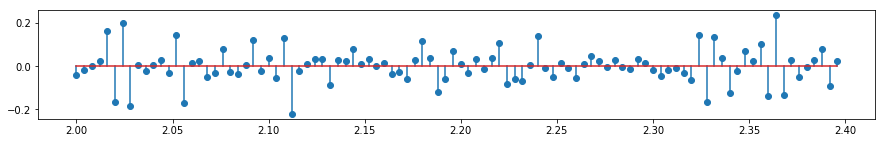

In [79]:
plt.figure(figsize=(15,2))
plt.stem(t_seis[500:600], rc[500:600])

## Convolve with a wavelet: `bruges`

In [80]:
from bruges.filters import ricker

w, t = ricker(0.128, 0.004, 20, return_t=True)

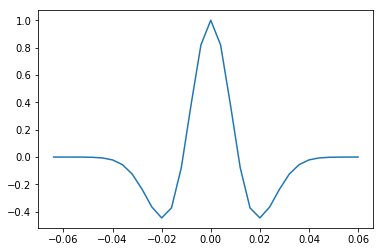

In [81]:
plt.plot(t, w)

In [82]:
syn = bruges.filters.convolve(rc, w)

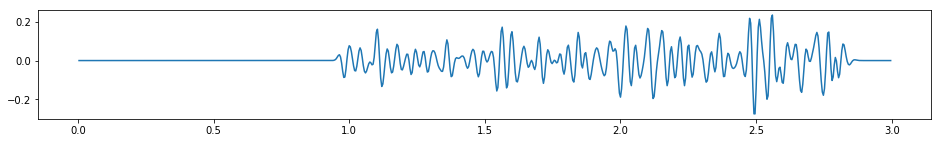

In [83]:
plt.figure(figsize=(16,2))
plt.plot(t_seis[1:], syn)

## Compare with the seismic: `segyio`

In [23]:
import segyio

with segyio.open('../data/Penobscot_xl1155.sgy') as s:
    seismic = segyio.cube(s)[0]

The synthetic is at trace number 77. We need to make a shifted version of the synthetic to overplot.

In [24]:
trace, gain = 77, 50
s = trace + gain*syn

And we can define semi-real-world cordinates of the seismic data:

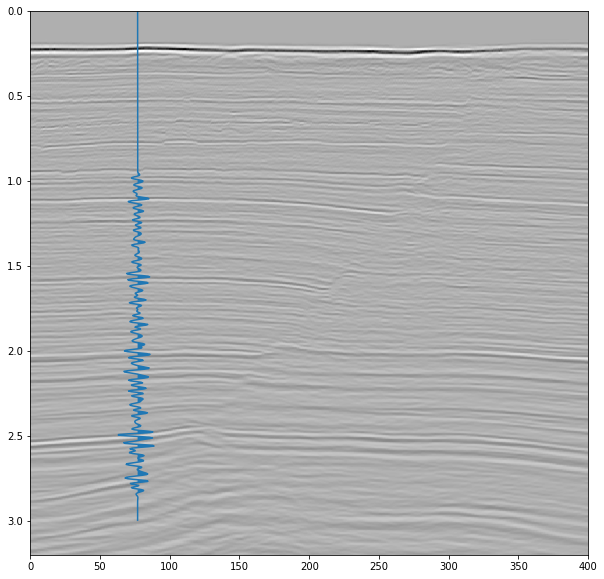

In [25]:
plt.figure(figsize=(10,10))
plt.imshow(seismic.T, cmap='Greys', extent=(0, 400, 4.0, 0), aspect='auto')
plt.plot(s, t_seis[1:])
plt.fill_betweenx(t_seis[1:], trace, s, where=syn>0, lw=0)
plt.xlim(0, 400)
plt.ylim(3.2, 0)
plt.show()

## Model a DTS log: `scikit` for now

We'd like to compute a gather, but this well doesn't have a shear sonic. Let's use another well to build a linear model from P-wave sonic and density.

First, we'll read data from another well and make our `X` matrix and and `y` vector:

In [30]:
r39 = Well.from_las('../data/R-39.las')

In [31]:
dts = r39.data['DT4S']

The DTS has some problems (try plotting it!), so we'll fix those:

In [32]:
dts[dts < 0] = np.nan
r39.data['DT4S'] = dts.interpolate()

In [33]:
X, y = r39.data_as_matrix(keys=['RHOB', 'DT4P']), r39.data['DT4S']

Now we can select and fit a model.

In [ ]:
from sklearn.linear_model import Lasso

regr = Lasso().fit(X, y)

Make an `X` for application...

In [57]:
X_appl = l30.data_as_matrix(keys=['RHOB', 'DT'])

...and apply the model to make a prediction for DTS:

In [58]:
dts = regr.predict(np.nan_to_num(X_appl))

Turn this into a curve.

In [60]:
from welly import Curve

dts = Curve(dts, basis=r39.data['DT4P'].basis)

Fix some problems with bad (probably casing) values at the top and bottom:

In [61]:
dts[dts < 100] = np.nan
dts = dts.interpolate()

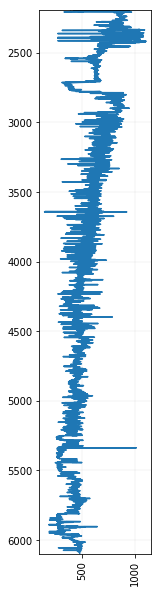

In [62]:
dts.plot()

In [63]:
l30.data['DTS'] = dts

## Compute offset gather

Now we can time-convert all the logs (before we just did the acoustic impedance log) and compute reflectivity.

In [70]:
vs = 1e6 / dts

vp_t, _ = time_convert(vp, dt_time)
vs_t, _ = time_convert(vs, dt_time)
rhob_t, _ = time_convert(rhob, dt_time)

In [71]:
import bruges

rc = bruges.reflection.reflectivity(vp_t, vs_t, rhob_t, theta=np.linspace(0, 45, 46))

In [72]:
rc.shape

(46, 749)

In [73]:
w = bruges.filters.ricker(0.128, 0.002, 40)

In [74]:
syn = bruges.filters.convolve(rc, w)

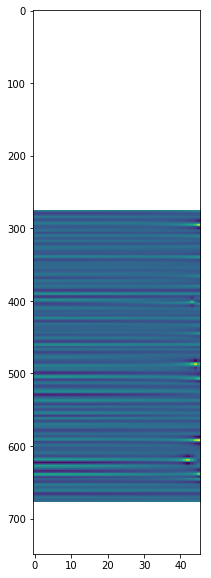

In [75]:
plt.figure(figsize=(3, 10))
plt.imshow(syn.real.T, aspect='auto')

<hr />

<div>
<img src="https://avatars1.githubusercontent.com/u/1692321?s=50"><p style="text-align:center">© Agile Geoscience 2018</p>
</div>